### Visualising the Singular Values of a Desired State (Example)

Use mps_env1

In [1]:
from mpsprep import MatrixProductState, MatrixProductInitializer
from mpsprep.helpers import (
    mean_fractional_entropy, coarse_truncate_s_vals,
    ranks_from_s_vals, state_fidelity,
    best_s_val_truncation_idx, 
    truncate_s_vals, generate_target_state,
)

import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial.chebyshev import chebval

from qiskit import QuantumCircuit, QuantumRegister, execute, Aer, transpile
from qiskit.quantum_info import Operator

Examples of States to Prepare

In [5]:
def random_haar_state_vector(dim):
    """
    Generates a random state vector drawn from the Haar measure in a d-dimensional Hilbert space.

    Parameters:
    dim (int): The dimension of the Hilbert space.

    Returns:
    numpy.ndarray: A normalized complex state vector of shape (dim,).
    """
    # Step 1: Generate a vector with complex entries.
    # Real and imaginary parts are sampled from a standard normal distribution.
    real_part = np.random.normal(0, 1, dim)
    imag_part = np.random.normal(0, 1, dim)
    state_vector = real_part + 1j * imag_part

    # Step 2: Normalize the vector to have unit norm.
    norm = np.linalg.norm(state_vector)
    if norm == 0:
        raise ValueError("Generated a zero vector; retrying might be necessary.")
    normalized_state_vector = state_vector / norm

    return normalized_state_vector


def random_state_vector(dim):
    """
    Generates a completely random state vector in a d-dimensional Hilbert space.
    The components of the vector are random complex numbers.
    
    Parameters:
    dim (int): The dimension of the Hilbert space.

    Returns:
    numpy.ndarray: A normalized complex state vector of shape (dim,).
    """
    # Step 1: Generate a vector with complex entries.
    # Real and imaginary parts are sampled from a uniform distribution over [0, 1).
    real_part = np.random.rand(dim)  # Uniform distribution over [0, 1)
    imag_part = np.random.rand(dim)  # Uniform distribution over [0, 1)
    state_vector = real_part + 1j * imag_part

    # Step 2: Normalize the vector to have unit norm.
    norm = np.linalg.norm(state_vector)
    if norm == 0:
        raise ValueError("Generated a zero vector; retrying might be necessary.")
    normalized_state_vector = state_vector / norm

    return normalized_state_vector


def generate_aklt_state_mps(num_qubits):
    """
    Generates the MPS representation of the AKLT state.
    
    Returns:
    mps (list of np.ndarray): The MPS represented as a list of tensors.
    """
    # AKLT tensors (with bond dimension 2) are predefined
    sqrt3 = np.sqrt(3)
    
    # Define the three local tensors (spin-1 space)
    A = np.array([
        [[0, 0], [0, 1]],   # A for |0> (spin 1 projection: -1)
        [[0, -1/sqrt3], [1/sqrt3, 0]],  # A for |1> (spin 1 projection: 0)
        [[-1, 0], [0, 0]]   # A for |2> (spin 1 projection: +1)
    ])
    
    # Repeat this tensor for all sites
    mps = [A for _ in range(num_qubits)]
    
    return mps

from itertools import product


def nearest_neighbor_entangled_state(num_qubits):
    """
    Generates a state vector representing a nearest-neighbor entangled pairs state.
    
    Parameters:
    num_qubits (int): The number of qubits in the state.
    
    Returns:
    np.ndarray: A 1D numpy array of size 2**num_qubits representing the state vector.
    """
    if num_qubits < 1:
        raise ValueError("Number of qubits must be at least 1.")
    
    # Determine number of pairs and if there's an unpaired qubit
    num_pairs = num_qubits // 2
    has_unpaired = num_qubits % 2
    
    # Each pair can be in |00> or |11>
    pair_states = ['00', '11']
    
    # Generate all possible combinations of pair states
    combinations = list(product(pair_states, repeat=num_pairs))
    
    # If there's an unpaired qubit, append '0' to each combination
    if has_unpaired:
        combinations = [combo + ('0',) for combo in combinations]
    
    # Initialize state vector with zeros
    state_size = 2 ** num_qubits
    state_vector = np.zeros(state_size, dtype=complex)
    
    # Calculate the normalization factor
    norm_factor = 1 / np.sqrt(len(combinations))
    
    for combo in combinations:
        # Join the bits to form the binary string
        bitstring = ''.join(combo)
        # Convert binary string to integer index
        index = int(bitstring, 2)
        # Set the amplitude
        state_vector[index] = norm_factor
    
    return state_vector

from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh

def heisenberg_ground_state(num_qubits):
    """
    Constructs the Heisenberg Hamiltonian for a 1D spin-1/2 chain and returns its ground state vector.

    Parameters:
        num_qubits (int): Number of qubits (spins) in the chain.

    Returns:
        ground_state (numpy.ndarray): Ground state vector of size 2**num_qubits.
    """
    # Define Pauli matrices
    Sx = 0.5 * np.array([[0, 1], [1, 0]], dtype=complex)
    Sy = 0.5 * np.array([[0, -1j], [1j, 0]], dtype=complex)
    Sz = 0.5 * np.array([[1, 0], [0, -1]], dtype=complex)
    
    # Convert to sparse matrices for efficiency
    Sx = csr_matrix(Sx)
    Sy = csr_matrix(Sy)
    Sz = csr_matrix(Sz)
    I = csr_matrix(identity(2, dtype=complex))
    
    H = csr_matrix((2**num_qubits, 2**num_qubits), dtype=complex)
    
    for i in range(num_qubits - 1):
        # List of operators for Sx_i Sx_{i+1}, Sy_i Sy_{i+1}, Sz_i Sz_{i+1}
        operators = []
        for S in [Sx, Sy, Sz]:
            op_list = []
            for j in range(num_qubits):
                if j == i or j == i + 1:
                    op_list.append(S)
                else:
                    op_list.append(I)
            # Tensor product
            term = op_list[0]
            for op in op_list[1:]:
                term = kron(term, op, format='csr')
            operators.append(term)
        
        # Add interaction terms to Hamiltonian
        H += operators[0] + operators[1] + operators[2]
    
    # Optionally, add periodic boundary conditions
    # Uncomment the following lines to include interaction between last and first qubit
    # i = num_qubits - 1
    # operators = []
    # for S in [Sx, Sy, Sz]:
    #     op_list = []
    #     for j in range(num_qubits):
    #         if j == i or j == 0:
    #             op_list.append(S)
    #         else:
    #             op_list.append(I)
    #     term = op_list[0]
    #     for op in op_list[1:]:
    #         term = kron(term, op, format='csr')
    #     operators.append(term)
    # H += operators[0] + operators[1] + operators[2]
    
    # Compute the ground state using sparse eigenvalue solver
    # eigsh finds the k smallest eigenvalues; here k=1 for the ground state
    eigenvalues, eigenvectors = eigsh(H, k=1, which='SA')  # 'SA' = smallest algebraic
    ground_state = eigenvectors[:, 0]
    
    return ground_state

def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func

Compute MPS From Any Input State Vector

In [3]:
def compute_MPS_from_state_vector(vec,n):
    f_tensor = vec.reshape((2,)*n, order="F")
    x_values = np.linspace(-1, 1, 2**n)
    MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(f_tensor)
    MPS_exact = MatrixProductState(MPS_cores_exact)

    return f_tensor,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact

Compute Approximation Error

In [7]:
def find_max_nth_elements(arrays, max_n=20):
    """
    Finds the maximum n-th element across all arrays for n from 1 to max_n.

    Parameters:
    - arrays (list of np.array): List containing NumPy arrays of varying lengths.
    - max_n (int): The maximum n for which to find the largest elements.

    Returns:
    - list: A list of maximum values for each n-th position from 1 to max_n.
    """
    # Initialize a list with -infinity for comparison
    max_elements = [float('-inf')] * max_n

    # Iterate through each array
    for idx, arr in enumerate(arrays):
        # Determine the number of elements to process (up to max_n)
        num_elements = min(len(arr), max_n)
        for i in range(num_elements):
            if arr[i] > max_elements[i]:
                max_elements[i] = arr[i]
                #print(f"Updated max for position {i+1}: {arr[i]} (from array index {idx})")

    return max_elements

def get_approximation_error(mps_exact,s_vals_exact,bond_dim,y_amp):
    thresholds = find_max_nth_elements(s_vals_exact, max_n=bond_dim)
    t = thresholds[-1]
    coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact, threshold=t)
    coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals) 
    min_s_val = max(len(arr) for arr in coarse_truncated_s_vals)
    MPS_cores_trunc, s_vals_trunc = MatrixProductState.svd_decompose(f_tensor, truncate_ranks=coarse_truncated_ranks)

    MPS_trunc = MatrixProductState(MPS_cores_trunc)

    MPS_trunc.right_normalize("F")
    y_mps_exact = MPS_trunc.get_all_amplitudes()

    print(f"State Fidelity (Exact): {state_fidelity(y_amp, y_mps_exact):.5f}")


### NOTE: This can be used to visualise any singular values. plot_singular_values3 is a modified version of the original plot_singular_values function for visual appeal.

e.g. Random State Vector

Exact core ranks = [2 4 8 8 4 2 1]
State Fidelity (Exact): 0.16384


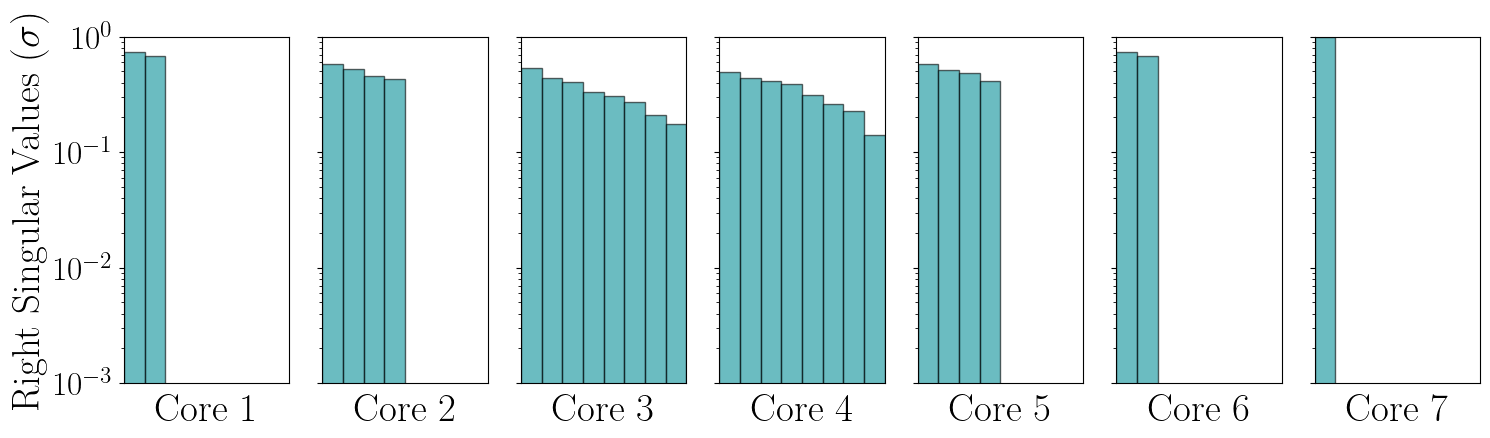

In [8]:
n = 7

state_vec = random_haar_state_vector(2**n)

f_tensor,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact = compute_MPS_from_state_vector(state_vec,n)

mps_ranks = ranks_from_s_vals(s_vals_exact) 
print('Exact core ranks = ' + str(mps_ranks))
custom_y_ticks = [1e-3, 1e-2, 1e-1, 1e-0]

get_approximation_error(MPS_exact,s_vals_exact,3,state_vec)

MPS_exact.plot_singular_values3(s_vals_exact,font_size=28,axis_val_font_size=24,y_ticks=custom_y_ticks,savefig=True,transparent=True,name=r"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Visualisation\haar_measure_7_plot.png",color="#089099",edgecolor="black",c_alpha=0.6)

e.g isotropic Heisenberg ground state

Exact core ranks = [2 4 8 8 4 2 1]
State Fidelity (Exact): 0.95043


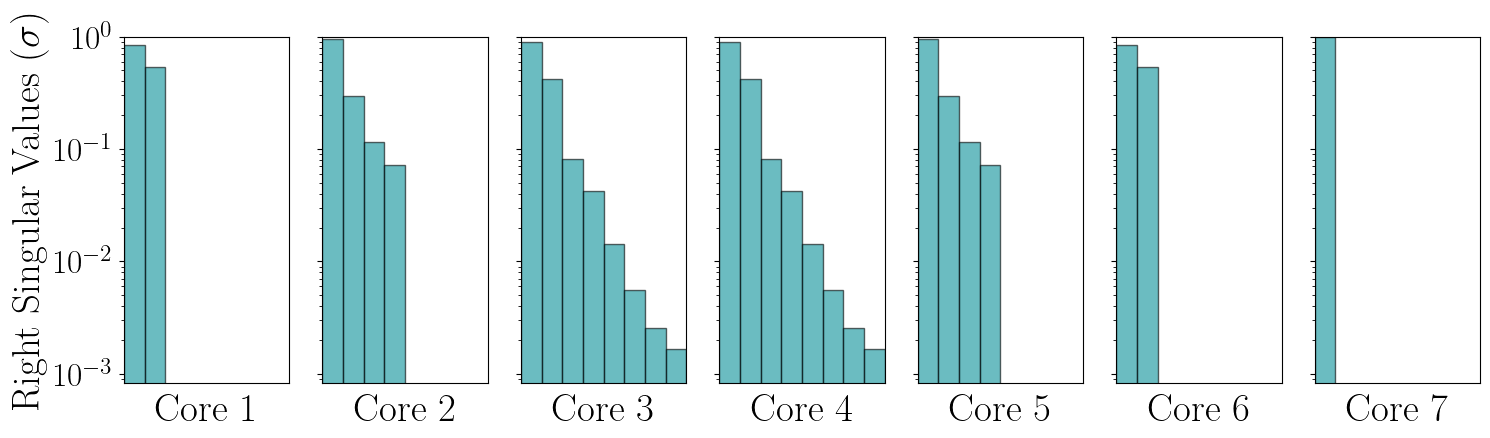

In [9]:
n = 7

state_vec = heisenberg_ground_state(n)

f_tensor,x_values, f_tensor, MPS_cores_exact, MPS_exact, s_vals_exact = compute_MPS_from_state_vector(state_vec,n)

mps_ranks = ranks_from_s_vals(s_vals_exact) 
print('Exact core ranks = ' + str(mps_ranks))
custom_y_ticks = [1e-3, 1e-2, 1e-1, 1e-0]

get_approximation_error(MPS_exact,s_vals_exact,3,state_vec)

MPS_exact.plot_singular_values3(s_vals_exact,font_size=28,axis_val_font_size=24,y_ticks=custom_y_ticks,savefig=True,transparent=True,name=r"C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\MPS Visualisation\heisenberg_7_plot.png",color="#089099",edgecolor="black",c_alpha=0.6)